# Inferring loads on an Euler Bernoulli beam

In [1]:
%matplotlib inline
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
matplotlib.rcParams['font.size'] = 16

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

# MUQ Includes
import pymuqModeling as mm
import pymuqApproximation as ma
import pymuqUtilities as mu

### Set up discretization

In [2]:
numPts = 200
dim = 1
x = np.linspace(0,1,numPts)[None,:]

### Set up the Gaussian Process prior

In [3]:
priorVar = 1.0
priorLength = 0.5
priorNu = 1.0/2.0 # must take the form N+1/2 for zero or odd N (i.e., {0,1,3,5,...})

kern = ma.MaternKernel(1, priorVar,priorLength, priorNu)

coDim = 1 # The dimension of the load field at a single point
mu = ma.ZeroMean(dim,coDim)

priorGP = ma.GaussianProcess(mu,kern)

### Plot prior samples

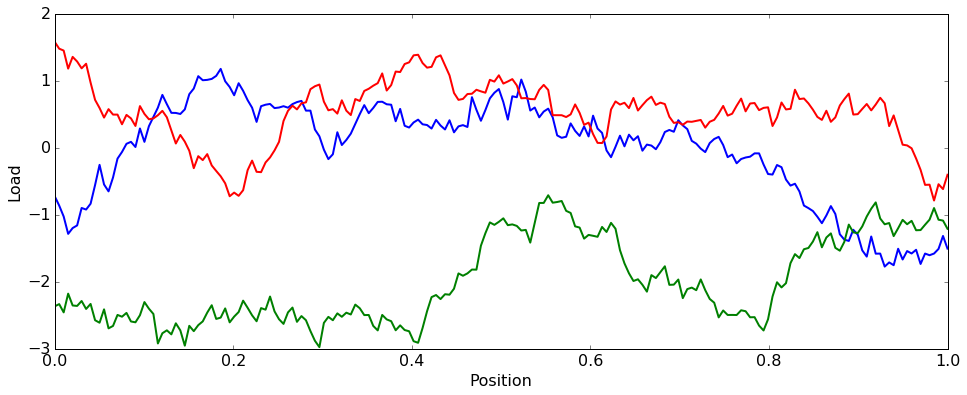

In [4]:
numSamps = 3

for i in range(numSamps):
    samp = priorGP.Sample(x)
    plt.plot(x[0,:], samp[0,:], linewidth=2)
    
plt.xlabel('Position')
plt.ylabel('Load')
plt.show()

### Set up model

### Compute posterior

In [5]:
prior = priorGP.Discretize(x)

numObs = 10
obsMat = np.random.randn(numObs,numPts)
data = np.random.randn((numObs))
obsCov = 1e-9*np.ones((numObs))

post = prior.Condition(obsMat, data, obsCov)

### Plot posterior

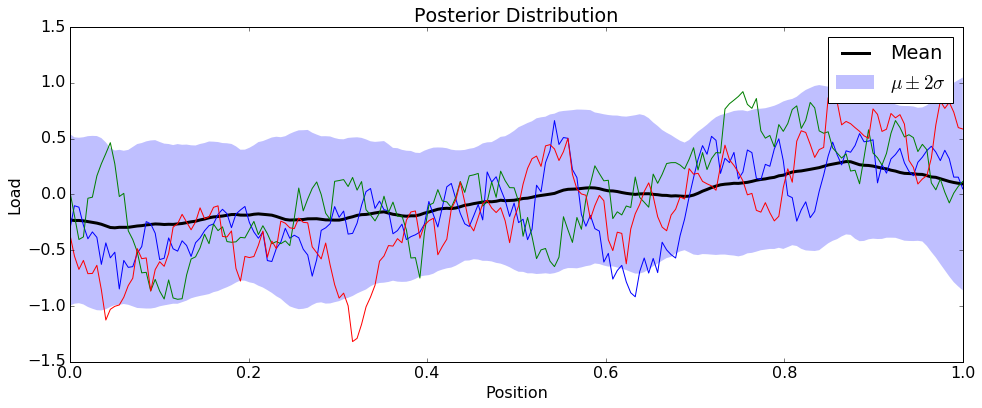

In [6]:
postMean = post.GetMean()
plt.plot(x.T, post.GetMean(), 'k', linewidth=3, label='Mean')

postCov = post.GetCovariance()
postStd = np.sqrt(np.diag(postCov))

plt.fill_between(x[0,:], postMean+2.0*postStd, postMean-2.0*postStd, alpha=0.25, edgecolor='None', label='$\mu \pm 2\sigma$')

for i in range(numSamps):
    samp = post.Sample()
    plt.plot(x.T, samp.T, linewidth=1)

plt.legend()
plt.title('Posterior Distribution')
plt.xlabel('Position')
plt.ylabel('Load')
plt.show()

## Analyze low-rank structure

The posterior precision is given by $\Gamma_{pos}^{-1} = H + \Gamma_{pr}^{-1}$, where $H$ is the Hessian of the log-likelihood function.  In this example, $H = A^T\Gamma_{obs}A$


In [32]:
import scipy.linalg as la

#### Likelihood Only

In [33]:
likelyHess = np.dot( obsMat.T, la.solve(np.diag(obsCov), obsMat))

vals, vecs = la.eigh(likelyHess)

/Users/rdcrlmdp/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


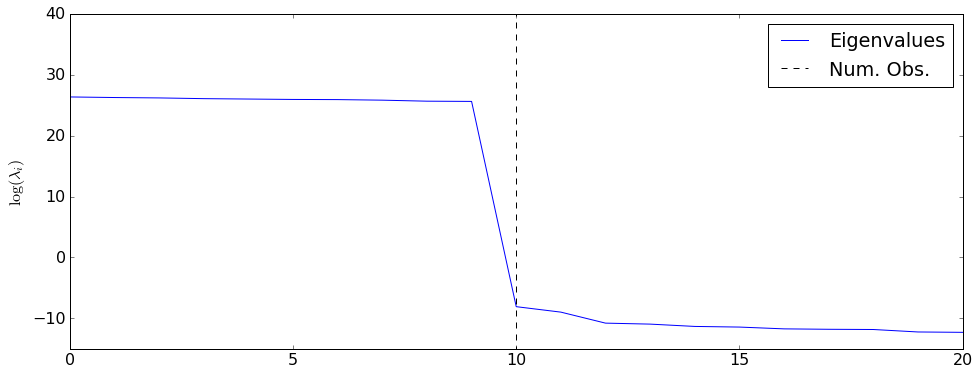

In [35]:
logVals = np.log(vals)
plt.plot(logVals[::-1], label='Eigenvalues')
plt.plot([numObs,numObs],[-100,100],'--k',label='Num. Obs.')
plt.ylim([-15,40])
plt.xlim([0,20])
plt.ylabel('$\log(\lambda_i)$')
plt.legend()

plt.show()

#### Likelihood-Informed Subspace

In [36]:
likelyHess = np.dot( obsMat.T, la.solve(np.diag(obsCov), obsMat))
priorPrec = prior.GetPrecision()

vals, vecs = la.eigh(likelyHess, priorPrec)

/Users/rdcrlmdp/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


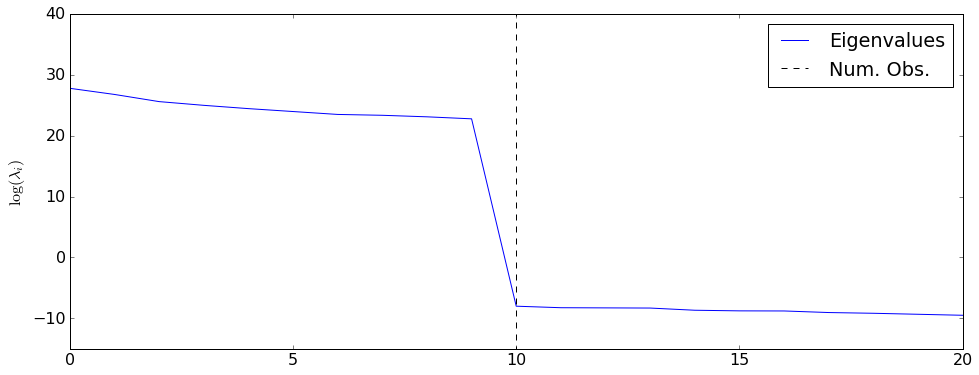

In [37]:

logVals = np.log(vals)
plt.plot(logVals[::-1], label='Eigenvalues')
plt.plot([numObs,numObs],[-100,100],'--k',label='Num. Obs.')
plt.ylim([-15,40])
plt.xlim([0,20])
plt.ylabel('$\log(\lambda_i)$')
plt.legend()
plt.show()